# Testing a CNN for ship detection on Google Clould

This is a simple exercise to test seting up, compilling C code, and train a CNN on a custom data set using a cloud GPU instance.

This is a reproduction of a ship-detection exercise implemented on the [Intel DevCloud Platform](https://devcloud.intel.com/edge/). Original article [here](https://medium.com/intel-software-innovators/ship-detection-in-satellite-images-from-scratch-849ccfcc3072).

For this example we used [YOLOv3](https://pjreddie.com/darknet/yolo/), a convolutional neural network for real-time object detection, wich is build on top of [Darknet](https://pjreddie.com/darknet/), an open-source neural network framework written in C and CUDA. YOLOv3 can run on both CPUs and GPUs, and its source code is relatively easy to modify/extend for specific needs (e.g. custom data I/O formats).

> **NOTE:** 
> Once I've got the GPU instance setup, the data in place and the CNN model up and running, I killed the training process. Training an accurate CNN model would require hours of GPU time (with an excessive cost)!

Machine type: `n1-highmem-8` (8 vCPUs, 52 GB memory, 1 NVIDIA Tesla P100 GPU)

## Download Darknet, set configuration for GPU, and build

Put the Darknet source code on your home dir

In [2]:
!git clone https://github.com/pjreddie/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 5901, done.
remote: Total 5901 (delta 0), reused 0 (delta 0), pack-reused 5901
Receiving objects: 100% (5901/5901), 6.17 MiB | 2.96 MiB/s, done.
Resolving deltas: 100% (3923/3923), done.


In [2]:
%cd darknet

/home/jupyter/gfw-problem/darknet


Change configuration files to run on GPUs (by default YOLOv3 runs on CPUs)

In [3]:
#! sed -i.bak 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i.bak 's/GPU=0/GPU=1/' Makefile
!sed -i.bak 's/CUDNN=0/CUDNN=1/' Makefile
!head Makefile

GPU=1
CUDNN=1
OPENCV=0
OPENMP=0
DEBUG=0

ARCH= -gencode arch=compute_30,code=sm_30 \
      -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52]


In [4]:
# verify CUDA installation
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [7]:
# Build Darknet
!make | tail -n 5

gcc -Iinclude/ -Isrc/ -DGPU -I/usr/local/cuda/include/ -DCUDNN  -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DGPU -DCUDNN obj/captcha.o obj/lsd.o obj/super.o obj/art.o obj/tag.o obj/cifar.o obj/go.o obj/rnn.o obj/segmenter.o obj/regressor.o obj/classifier.o obj/coco.o obj/yolo.o obj/detector.o obj/nightmare.o obj/instance-segmenter.o obj/darknet.o libdarknet.a -o darknet -lm -pthread  -L/usr/local/cuda/lib64 -lcuda -lcudart -lcublas -lcurand -lcudnn -lstdc++  libdarknet.a


# Download pre-trained weights and test

In [24]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2020-04-18 15:13:50--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com... 128.208.4.108
Connecting to pjreddie.com|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M   481KB/s    in 6m 13s  

2020-04-18 15:20:04 (425 KB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]

--2020-04-18 15:20:05--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com... 128.208.4.108
Connecting to pjreddie.com|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   709KB/s    in 7m 41s  

2020-04-18 15:27:48 (525 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [8]:
# Run the detector out of the box to test build
!./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

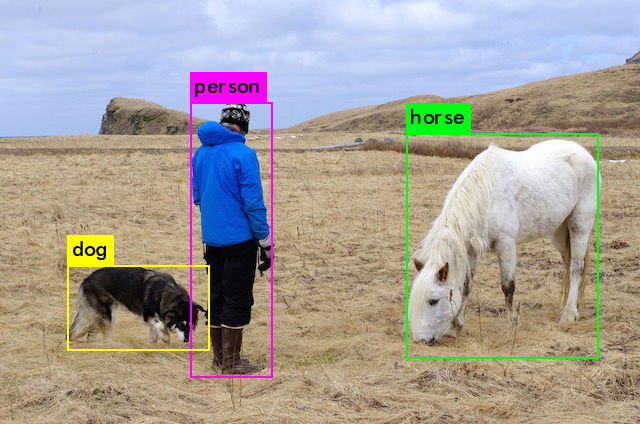

In [30]:
# Inspect prediction bounding boxes
from IPython.display import Image
Image('predictions.jpg')

## Pull labeled Planet images from GitHub repository

In [38]:
%cd ..
!git clone https://github.com/amanbasu/ship-detection.git planet

/Users/paolofer/work/gfw-problem
Cloning into 'ship-detection'...
remote: Enumerating objects: 606, done.
remote: Total 606 (delta 0), reused 0 (delta 0), pack-reused 606
Receiving objects: 100% (606/606), 140.72 MiB | 4.64 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Checking out files: 100% (582/582), done.


## Train custom object detector with ship images

In [11]:
# Copy ship config files to Darknet folder
!cp cfg/ship.data darknet/data/
!cp cfg/ship.cfg darknet/cfg/
!cp cfg/ship.names darknet/data/

/home/jupyter/gfw-problem


In [ ]:
# Train the model. This will take a few hours! If connection breaks, continue from backup weights
%cd darknet/
!./darknet detector train data/ship.data cfg/ship.cfg darknet53.conv.74 -dont_show

Loading weights from darknet53.conv.74...Done!  
Learning Rate: 0.001, Momentum: 0.9, Decay: 0.0005  
Resizing  
480  
Loaded: 0.000075 seconds  
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.527077, .5R: -nan, .75R: -nan,  count: 0   
Region 94 Avg IOU: 0.207846, Class: 0.617133, Obj: 0.457685, No Obj: 0.496262, .5R: 0.000000, .75R: 0.000000,  count: 4  
Region 106 Avg IOU: 0.173112, Class: 0.435877, Obj: 0.261933, No Obj: 0.414595, .5R: 0.000000, .75R: 0.000000,  count: 4  
1: 1099.030396, 1099.030396 avg, 0.000000 rate, 0.066095 seconds, 2 images  
Loaded: 0.055151 seconds  
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.528747, .5R: -nan, .75R: -nan,  count: 0  
Region 94 Avg IOU: 0.207633, Class: 0.344811, Obj: 0.390235, No Obj: 0.495240, .5R: 0.000000, .75R: 0.000000,  count: 2  
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.416965, .5R: -nan, .75R: -nan,  count: 0   
2: 1086.663696, 1097.793701 avg, 0.000000 rate, 0.074491 seconds, 4 images  
Loaded: 0.004540 seconds  
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.531583, .5R: -nan, .75R: -nan,  count: 0  
Region 94 Avg IOU: 0.022338, Class: 0.955851, Obj: 0.402492, No Obj: 0.494600, .5R: 0.000000, .75R: 0.000000,  count: 1  
Region 106 Avg IOU: 0.055172, Class: 0.162720, Obj: 0.092678, No Obj: 0.417063, .5R: 0.000000, .75R: 0.000000,  count: 1  
3: 1087.203491, 1096.734619 avg, 0.000000 rate, 0.125297 seconds, 6 images  
Loaded: 0.000133 seconds  
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.530534, .5R: -nan, .75R: -nan,  count: 0  
Region 94 Avg IOU: 0.242758, Class: 0.551366, Obj: 0.421911, No Obj: 0.495294, .5R: 0.166667, .75R: 0.000000,  count: 6  
Region 106 Avg IOU: 0.174974, Class: 0.469550, Obj: 0.618713, No Obj: 0.414698, .5R: 0.000000, .75R: 0.000000,  count: 3  
4: 1095.776855, 1096.638794 avg, 0.000000 rate, 0.133213 seconds, 8 images  
Loaded: 0.000120 seconds  
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.529558, .5R: -nan, .75R: -nan,  count: 0  
Region 94 Avg IOU: 0.172063, Class: 0.302610, Obj: 0.480462, No Obj: 0.494986, .5R: 0.000000, .75R: 0.000000,  count: 2  
Region 106 Avg IOU: 0.116722, Class: 0.528741, Obj: 0.223341, No Obj: 0.414763, .5R: 0.000000, .75R: 0.000000,  count: 2  
5: 1092.005737, 1096.175537 avg, 0.000000 rate, 0.131240 seconds, 10 images  
Loaded: 0.000078 seconds  
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.529429, .5R: -nan, .75R: -nan,  count: 0  
Region 94 Avg IOU: 0.208842, Class: 0.451372, Obj: 0.579845, No Obj: 0.496783, .5R: 0.125000, .75R: 0.000000,  count: 8  
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413299, .5R: -nan, .75R: -nan,  count: 0  
...  

[Training interrupted]  

In [15]:
# Inspect performance when training is done: average loss per iteration
# from IPython.display import Image
# Image('chart.png')

In [39]:
# Set custom cfg file to test mode (it was set to train)
%cd cfg/
!sed -i.bak 's/batch=2/batch=1/' ship.cfg
!head ship.cfg
%cd ..

/home/jupyter/gfw-problem/darknet/cfg
[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=1
subdivisions=1
width=512
height=512
channels=3
/home/jupyter/gfw-problem/darknet


In [48]:
# Test trained model on random image (set detection threshold)
!./darknet detector test data/ship.data cfg/ship.cfg backup/ship_600.weights ../planet/dataset/20190509_030504_1010_3B_Visual_3.png -thresh 0.15

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   512 x 512 x   3   ->   512 x 512 x  32  0.453 BFLOPs
    1 conv     64  3 x 3 / 2   512 x 512 x  32   ->   256 x 256 x  64  2.416 BFLOPs
    2 conv     32  1 x 1 / 1   256 x 256 x  64   ->   256 x 256 x  32  0.268 BFLOPs
    3 conv     64  3 x 3 / 1   256 x 256 x  32   ->   256 x 256 x  64  2.416 BFLOPs
    4 res    1                 256 x 256 x  64   ->   256 x 256 x  64
    5 conv    128  3 x 3 / 2   256 x 256 x  64   ->   128 x 128 x 128  2.416 BFLOPs
    6 conv     64  1 x 1 / 1   128 x 128 x 128   ->   128 x 128 x  64  0.268 BFLOPs
    7 conv    128  3 x 3 / 1   128 x 128 x  64   ->   128 x 128 x 128  2.416 BFLOPs
    8 res    5                 128 x 128 x 128   ->   128 x 128 x 128
    9 conv     64  1 x 1 / 1   128 x 128 x 128   ->   128 x 128 x  64  0.268 BFLOPs
   10 conv    128  3 x 3 / 1   128 x 128 x  64   ->   128 x 128 x 128  2.416 BFLOPs
   11 res    8                 128 x 

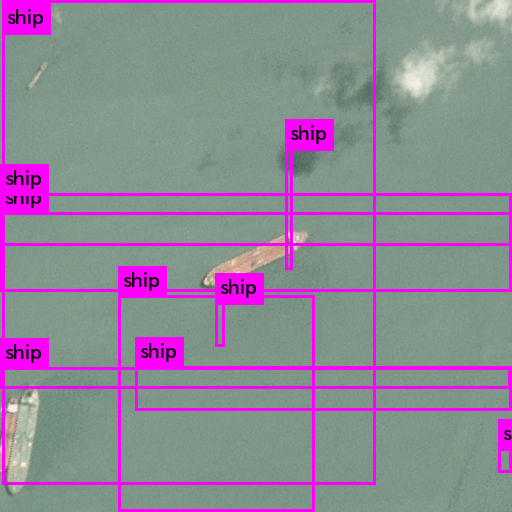

In [46]:
Image('predictions.jpg')

If predictions are not good, keep training from last saved weights

In [49]:
# Set back custom cfg file to train mode
%cd cfg/
!sed -i.bak 's/batch=1/batch=2/' ship.cfg
!head ship.cfg
%cd ..

/home/jupyter/gfw-problem/darknet/cfg
[net]
# Testing
# batch=2
# subdivisions=1
# Training
batch=2
subdivisions=1
width=512
height=512
channels=3
/home/jupyter/gfw-problem/darknet


In [ ]:
!./darknet detector train data/ship.data cfg/ship.cfg backup/ship_900.weights -dont_show